In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load the CIFAR-10 dataset
from tensorflow.keras import datasets
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
# Normalize the pixel values of images to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
# Split the training data into training and validation sets (20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Convert the labels to categorical (if necessary)
y_train = to_categorical(y_train.reshape(-1), 10)
y_val = to_categorical(y_val.reshape(-1), 10)
y_test = to_categorical(y_test.reshape(-1), 10)

In [ ]:
# Define Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow((1 - y_pred), gamma)
        focal_loss = weight * cross_entropy
        return tf.reduce_sum(focal_loss, axis=1)
    return focal_loss_fixed

In [ ]:
# Function to create and compile the model
def create_model():
    model = Sequential()
    pretrained_model = ResNet50(include_top=False, input_shape=(32, 32, 3), pooling='avg', weights='imagenet')

    # Unfreeze layers for fine-tuning
    for layer in pretrained_model.layers:
        layer.trainable = True

    # Add the pre-trained model and additional layers
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile with Focal Loss
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=focal_loss(gamma=2.0, alpha=0.25),
                  metrics=['accuracy'])
    return model

In [ ]:
# Ensemble of models (e.g., 3 models)
num_models = 3
models = [create_model() for _ in range(num_models)]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Train each model in the ensemble
history_list = []
epochs = 20
for i, model in enumerate(models):
    print(f"\nTraining model {i + 1}/{num_models}")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
    history_list.append(history)


Training model 1/3
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 34ms/step - accuracy: 0.4255 - loss: 0.3259 - val_accuracy: 0.6559 - val_loss: 0.1529
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.6973 - loss: 0.1280 - val_accuracy: 0.7398 - val_loss: 0.1117
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7713 - loss: 0.0868 - val_accuracy: 0.7408 - val_loss: 0.1070
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.8195 - loss: 0.0631 - val_accuracy: 0.7619 - val_loss: 0.0998
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.8544 - loss: 0.0483 - val_accuracy: 0.7718 - val_loss: 0.1048
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.8808 - loss: 0.0389 - val_accuracy: 0.7845 - val_loss: 0.0993
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.8994 - loss: 0.0322 - val_accuracy: 0.7798 - val_loss: 0.1028
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step 

In [ ]:
# Get the best training and validation accuracy
best_train_accuracy = max(history.history['accuracy'])
best_val_accuracy = max(history.history['val_accuracy'])

# Get the lowest training and validation loss
lowest_train_loss = min(history.history['loss'])
lowest_val_loss = min(history.history['val_loss'])

print(f"Best Training Accuracy: {best_train_accuracy * 100:.2f}%")
print(f"Best Validation Accuracy: {best_val_accuracy * 100:.2f}%")
print(f"Lowest Training Loss: {lowest_train_loss:.4f}")
print(f"Lowest Validation Loss: {lowest_val_loss:.4f}")

Best Training Accuracy: 97.15%
Best Validation Accuracy: 81.27%
Lowest Training Loss: 0.0081
Lowest Validation Loss: 0.0985


In [ ]:
# Evaluate each model on the test data and average the predictions
predictions = np.zeros((X_test.shape[0], 10))  # 10 classes

In [ ]:
for model in models:
    predictions += model.predict(X_test) / num_models  # Averaging predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step


In [ ]:
# Calculate final metrics using averaged predictions
y_pred_classes = np.argmax(predictions, axis=1)  # Convert predictions to class indices
y_true_classes = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

In [ ]:
# Display the classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.87      0.87      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.85      0.78      0.81      1000
         cat       0.68      0.74      0.71      1000
        deer       0.81      0.85      0.83      1000
         dog       0.76      0.75      0.75      1000
        frog       0.92      0.86      0.89      1000
       horse       0.90      0.87      0.88      1000
        ship       0.91      0.92      0.92      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# Calculate and display success rate for each class
print("\nSuccess Rate for Each Class:")
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
for i, class_name in enumerate(class_names):
    true_positive = conf_matrix[i, i]  # Correct predictions for this class
    total_actual = np.sum(conf_matrix[i, :])  # Total instances of this class in the test set
    success_rate = true_positive / total_actual * 100  # Calculate success rate
    print(f"{class_name}: {true_positive}/{total_actual} ({success_rate:.2f}%)")


Success Rate for Each Class:
airplane: 867/1000 (86.70%)
automobile: 909/1000 (90.90%)
bird: 783/1000 (78.30%)
cat: 739/1000 (73.90%)
deer: 852/1000 (85.20%)
dog: 748/1000 (74.80%)
frog: 861/1000 (86.10%)
horse: 870/1000 (87.00%)
ship: 921/1000 (92.10%)
truck: 916/1000 (91.60%)


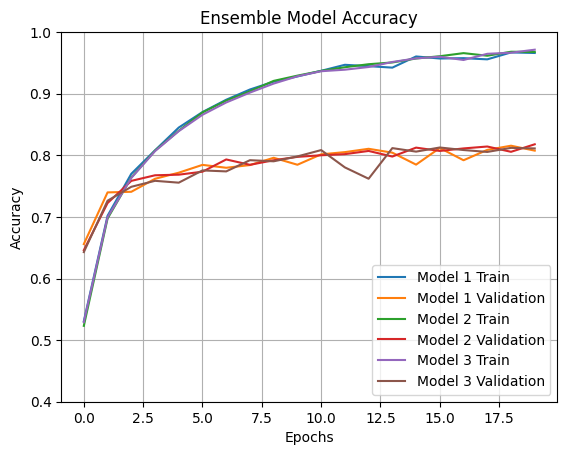

In [ ]:
# Plot accuracy for each model in the ensemble
for i, history in enumerate(history_list):
    plt.plot(history.history['accuracy'], label=f'Model {i+1} Train')
    plt.plot(history.history['val_accuracy'], label=f'Model {i+1} Validation')
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Ensemble Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

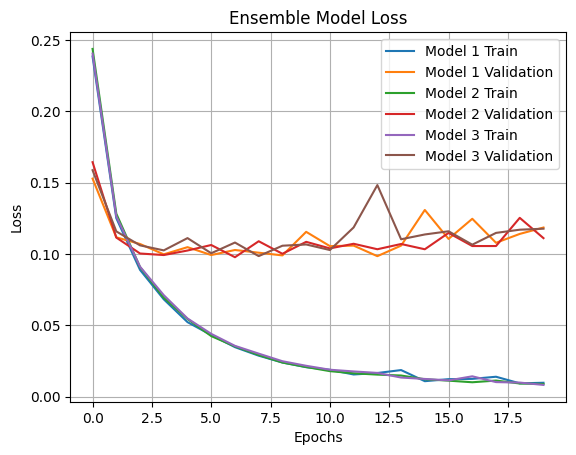

In [ ]:
# Plot loss for each model in the ensemble
for i, history in enumerate(history_list):
    plt.plot(history.history['loss'], label=f'Model {i+1} Train')
    plt.plot(history.history['val_loss'], label=f'Model {i+1} Validation')
plt.grid()
plt.title('Ensemble Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()